# Optimal Control

In [336]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import qutip_qtrl.pulseoptim as cpo
import scqubits as scq

In [337]:
levels = 3
fluxonium = scq.Fluxonium(EJ=8.9, EC=2.5, EL=0.5, flux=0.48, cutoff=110)
c_ops = None  # will be initialized once below

In [338]:
def init_c_ops():
    gamma_ij = {}
    for j in range(1, levels):
        for i in range(j):
            t1 = fluxonium.t1_capacitive(j, i, Q_cap=1e5, total=False)
            if t1 is not None and t1 > 0:
                rate = 1.0 / t1
                gamma_ij[(i, j)] = rate
                gamma_ij[(j, i)] = rate
    c_ops_local = []
    for (i, j), gamma in gamma_ij.items():
        cop = np.sqrt(gamma) * qt.basis(levels, i) * qt.basis(levels, j).dag()
        c_ops_local.append(cop)
    return c_ops_local

In [339]:
scq.settings.T1_DEFAULT_WARNING=False


if c_ops is None:
    c_ops = init_c_ops()

evals, evecs = fluxonium.eigensys(evals_count=levels)
n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))
H0 = qt.Qobj(np.diag(evals))
A = 0.1
drive_op = n_op_energy_basis
H = [H0, [A * drive_op, 'cos(wd * t)']]

In [340]:
def evolve(omega_d, t_g):
    # global c_ops
    # if c_ops is None:
    #     c_ops = init_c_ops()

    # evals, evecs = fluxonium.eigensys(evals_count=levels)
    # n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))
    # H0 = qt.Qobj(np.diag(evals))
    # A = 0.1
    # drive_op = n_op_energy_basis
    # H = [H0, [A * drive_op, 'cos(wd * t)']]
    args = {'wd': omega_d}
    options = qt.Options(nsteps=1000000, store_states=True, atol=1e-10, rtol=1e-9)

    propagator = qt.propagator(H, t_g, args=args, options=options, c_ops=c_ops)
    propagator_kraus = qt.to_kraus(propagator)
    propagator_2x2 = [qt.Qobj(k.full()[:2, :2]) for k in propagator_kraus]
    p_2x2_super = qt.kraus_to_super(propagator_2x2)
    fidelity = qt.average_gate_fidelity(p_2x2_super, qt.sigmax())
    print("completed iteration")
    return fidelity

def wrapped_evolve(args):
    return evolve(*args)


-------------------

## New Data

In [341]:
levels = 6
fluxonium = scq.Fluxonium(EJ=8.9, EC=2.5, EL=0.48, flux=0.48, cutoff=110)

In [342]:
evals, evecs = fluxonium.eigensys(evals_count=levels)

n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))

H0 = qt.Qobj(np.diag(evals))

#note that this A is not actually used (it is what is being solved for technically)
#i kept it for consistency with the previous code
A = 0.4 * 2 * np.pi


H_ctrl = [n_op_energy_basis] # all from the previous code

In [343]:
U_0 = qt.qeye(levels)
U_0

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dia, isherm=True
Qobj data =
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

In [344]:
# Create a target unitary that is an X gate on the lowest two levels and identity on the rest
U_target = qt.qeye(levels).full()
U_target[0, 0] = 0
U_target[1, 1] = 0
U_target[0, 1] = 1
U_target[1, 0] = 1
U_target = qt.Qobj(U_target)

#done manually to make it easier to read, not realistic to experimental design

U_target

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

In [345]:
H_drift = H0

H_drift

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-0.7847313   0.          0.          0.          0.          0.        ]
 [ 0.         -0.28896388  0.          0.          0.          0.        ]
 [ 0.          0.          8.66889317  0.          0.          0.        ]
 [ 0.          0.          0.         11.56645634  0.          0.        ]
 [ 0.          0.          0.          0.         15.94800101  0.        ]
 [ 0.          0.          0.          0.          0.         16.91666724]]

In [346]:
result = cpo.optimize_pulse_unitary(
    H_drift, #H_0
    H_ctrl, #drive op in eigenbasis
    U_0, #identity
    U_target,
    num_tslots=1000,
    evo_time=(2 * np.pi),
    amp_lbound=None,
    amp_ubound=None,
    fid_err_targ=1e-9,
    max_iter=1000,
    max_wall_time=20,
    alg="GRAPE",
    optim_method="FMIN_L_BFGS_B",
    method_params={
        "disp": True,
        "maxiter": 1000,
    },
)

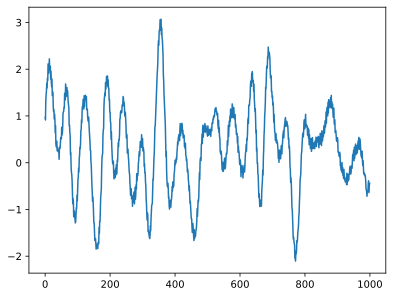

In [347]:
plt.plot(result.final_amps / (2 * np.pi))


In [348]:
U_f = result.evo_full_final

U_f

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-3.94771397e-05+1.86336798e-06j  2.74871252e-02+9.99622134e-01j
  -3.93251675e-05+1.17515721e-05j -2.10674244e-05-8.64844055e-06j
   1.20241119e-05-1.32813392e-04j  1.41088545e-05+1.60812456e-04j]
 [ 2.76585847e-02+9.99617410e-01j -3.94875160e-05+3.26640689e-07j
   3.25727284e-05+3.11447833e-06j  3.53367922e-05+2.21864154e-05j
   6.50554090e-05+8.09685200e-05j -1.42124461e-04+1.40856380e-05j]
 [ 3.23587401e-05-4.93235164e-06j -3.98902427e-05-9.55181236e-06j
   2.76076184e-02+9.99618826e-01j -2.83743585e-05+3.45692092e-05j
   6.19414163e-05+6.69662454e-05j -8.92807937e-05-3.94910160e-05j]
 [ 3.40329579e-05-2.41282939e-05j -2.05272149e-05+9.77639044e-06j
  -3.02635965e-05-3.29581028e-05j  2.76864120e-02+9.99616639e-01j
   5.05858868e-05-2.21262062e-05j -1.31053694e-04+1.17105951e-04j]
 [ 6.04830617e-05-8.44438708e-05j  1.93250136e-05+1.31961844e-04j
   5.81452861e-05-7.02836619e-05j  5.173

In [349]:
fidelity = qt.process_fidelity(U_f, U_target)

print("Fidelity: ", fidelity)

def count_nines_after_decimal(x):
    s = f"{x:.20f}"
    decimal_part = s.split(".")[1]
    count = 0
    for c in decimal_part:
        if c == "9":
            count += 1
        else:
            break
    return count

print("Number of nines after decimal:", count_nines_after_decimal(fidelity))


Fidelity:  0.9999999432149895
Number of nines after decimal: 7


In [350]:
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))


********* Summary *****************
Initial fidelity error 0.6426587511115207
Final fidelity error 2.8392505679875057e-08
Final gradient normal 1.8341956927453271e-06
Terminated due to function converged
Number of iterations 119


-------------------

## Implementing Noise

In [351]:
gamma_ij = {}
for j in range(1, levels):
    for i in range(j):
        t1 = fluxonium.t1_capacitive(j, i, Q_cap=1e5)
        if t1 is not None and t1 > 0:
            rate = 1.0 / t1
            gamma_ij[(i, j)] = rate
            gamma_ij[(j, i)] = rate  
gamma_ij

c_ops = []
for (i, j), gamma in gamma_ij.items():
    # |i><j| operator
    cop = (np.sqrt(gamma)) * qt.basis(levels, i) * qt.basis(levels, j).dag()
    c_ops.append(cop)

# c_ops

In [352]:
# sigma X control
LC_x = qt.liouvillian(qt.sigmax())
# sigma Y control
LC_y = qt.liouvillian(qt.sigmay())
# sigma Z control
LC_z = qt.liouvillian(qt.sigmaz())

L_drift = qt.liouvillian(H_drift)

gamma = 0.1
L0 = qt.liouvillian(H0, c_ops=c_ops)


In [353]:
# Drift
drift = L0

E0 = qt.sprepost(U_0, U_0)

E_targ = qt.sprepost(U_target, U_target)

In [354]:
# Apply the Liouvillian to each element in H_ctrl and update H_ctrl in-place
H_ctrl.clear()
for operator in [n_op_energy_basis]:  # original H_ctrl had [n_op_energy_basis]
    H_ctrl.append(qt.liouvillian(operator))

In [355]:
result = cpo.optimize_pulse(
    drift,
    H_ctrl, #source of the error
    E0, 
    E_targ,
    num_tslots=1000,
    evo_time=(2 * np.pi),
    amp_lbound=None,
    amp_ubound=None,
    fid_err_targ=1e-9,
    max_iter=1000,
    max_wall_time=100,
    alg="GRAPE",
    optim_method="FMIN_L_BFGS_B",
    # optim_method="Nelder-Mead",
    method_params={
        "disp": True,
        "maxiter": 1000,
    },
)

In [356]:
U_f_noise = result.evo_full_final

U_f_noise

Quantum object: dims=[[[6], [6]], [[6], [6]]], shape=(36, 36), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 6.49450843e-04-2.30590658e-16j -6.71785164e-06+4.13729111e-05j
  -4.64699265e-05+3.05098146e-05j ...  1.05610263e-04+1.34442749e-04j
   1.28988887e-04-3.80196226e-05j  8.65622381e-04-5.32846796e-16j]
 [-1.02429516e-05+3.17748005e-05j -4.97289794e-05-1.05061917e-04j
  -5.29849494e-07-8.65791560e-05j ... -1.14185212e-04+6.43332883e-05j
  -4.49250586e-05+5.99812201e-05j  3.42651473e-06-6.92327413e-05j]
 [ 3.92695417e-05-9.66261106e-05j  4.77456165e-06+5.47372700e-05j
   8.64132892e-05-9.67547491e-07j ...  4.88874705e-05+2.32761094e-07j
   1.27589190e-05-1.01892594e-05j -6.71684027e-05-4.20858904e-05j]
 ...
 [ 9.43176450e-05-7.83933601e-05j  1.68733635e-05+9.78460758e-05j
   8.44323275e-06+5.88135678e-05j ...  9.94782536e-01-1.23758556e-04j
  -1.80717721e-04+7.59875038e-05j -1.27187180e-04+1.81190356e-04j]
 [ 8.71263609e-05+2.58756731e-06j -5.38398556e-05+5.72784413e-05j
  

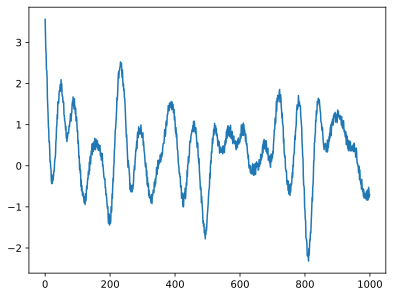

In [357]:
plt.plot(result.final_amps / (2 * np.pi))


In [358]:
fidelity_noise = qt.process_fidelity(U_f_noise, U_target)

print("Fidelity: ", fidelity_noise)

print("Number of nines after decimal:", count_nines_after_decimal(fidelity_noise))


Fidelity:  0.9950009014833392
Number of nines after decimal: 2


In [359]:
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))


********* Summary *****************
Initial fidelity error 0.8676416619085753
Final fidelity error 1.3133012017655591e-05
Final gradient normal 2.612521610713645e-06
Terminated due to function converged
Number of iterations 137
